In [21]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from utils import normalize
from torch.utils.data import DataLoader

from mod_moving_mnist import ModMovingMNISTDataset
from mpnnlstm import NextFramePredictorS2S
from model import MPNNLSTM, MPNNLSTMI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

def collate_fn(batch):
    return batch[0]


input_features = 1
input_timesteps=3
output_timesteps=3

# Create a dataset using the modified MovingMNIST
mnist_kwargs = dict(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    n_digits=1,
    gap=0,
    canvas_size=(32, 32),
    digit_size=(18, 18),
    pixel_noise=0.05,
    velocity_noise=0.1  # 0.15
)

# Create a train set (500), test set (50), and validation set (50)
data_train = ModMovingMNISTDataset(100, **mnist_kwargs)
data_test = ModMovingMNISTDataset(50, **mnist_kwargs)
data_val = ModMovingMNISTDataset(50, **mnist_kwargs)

loader_train = DataLoader(data_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
loader_test = DataLoader(data_test, batch_size=1, shuffle=True, collate_fn=collate_fn)
loader_val = DataLoader(data_val, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [74]:
from mpnnlstm import NextFramePredictor
from seq2seq import Seq2Seq

from torch.optim.lr_scheduler import StepLR
import time
import pandas as pd
from tqdm import tqdm

from graph_functions import image_to_graph, flatten, create_graph_structure, unflatten
from utils import add_positional_encoding

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
nn = Seq2Seq(
    thresh=0.5,
    hidden_size=64,
    dropout=0.1,
    input_features=1+3,
    output_timesteps=output_timesteps,
    n_layers=3).float()


model = NextFramePredictorS2S(
    nn,
    thresh=0.5,
    experiment_name='test',
    decompose=True,
    input_features=1,
    device=[device],
    output_timesteps=output_timesteps)

model.get_n_params()

176513

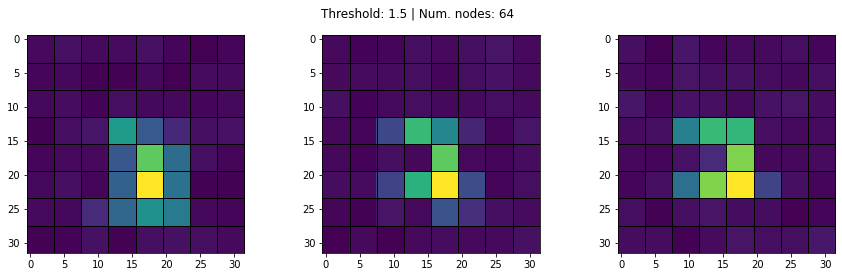

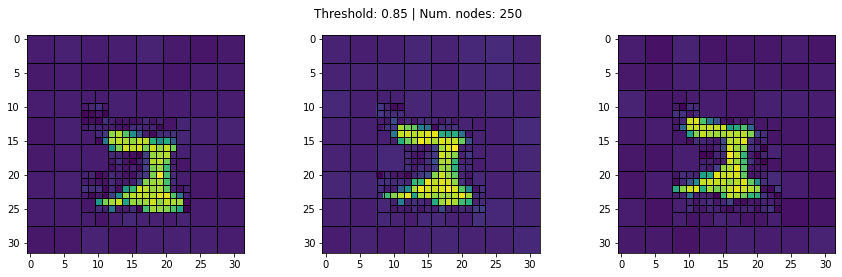

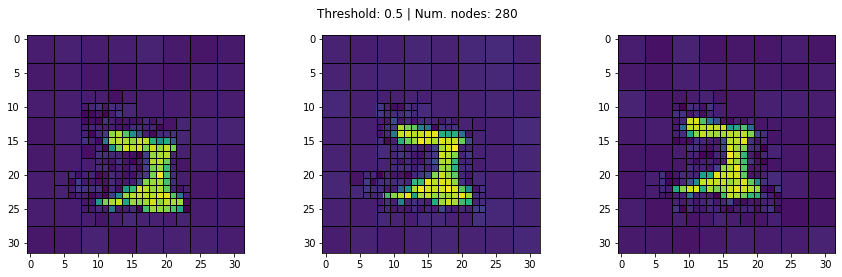

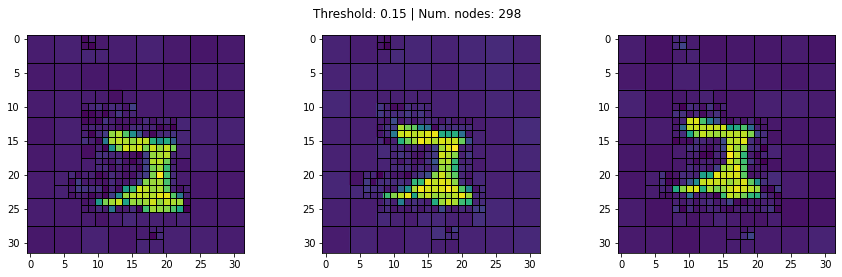

In [14]:
frame_index = 0

x = loader_val.dataset.x

fig, axs = model.test_threshold(x, thresh=1.5, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.85, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.5, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.15, frame_index=frame_index)
plt.show()

In [72]:
import cProfile
loader_profile = DataLoader(data_train, batch_size=1, sampler=torch.utils.data.SubsetRandomSampler(range(10)))
cProfile.run('model.train(loader_profile, loader_profile, lr=0.01, n_epochs=1)', sort=1)

0


         92416210 function calls (86189341 primitive calls) in 118.161 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       53   22.815    0.430   38.369    0.724 graph_functions.py:245(flatten)
       30   19.096    0.637   26.006    0.867 graph_functions.py:314(unflatten)
       10   14.654    1.465   14.654    1.465 {method 'run_backward' of 'torch._C._EngineBase' objects}
       53    7.164    0.135    7.164    0.135 graph_functions.py:259(<dictcomp>)
   690059    7.160    0.000    7.160    0.000 {built-in method torch.mean}
       23    5.264    0.229    6.240    0.271 graph_functions.py:166(get_adj)
5620454/130    4.210    0.000   11.759    0.090 storage.py:521(recursive_apply)
  3330/20    4.138    0.001   84.941    4.247 module.py:1184(_call_impl)
     1920    3.329    0.002    3.329    0.002 {method 'scatter_add_' of 'torch._C._TensorBase' objects}
   379832    3.029    0.000    3.029    0.000 {method 'unbind' of

ValueError: too many values to unpack (expected 5)

In [75]:
model.train(loader_train, loader_test, lr=0.09, n_epochs=20)

KeyboardInterrupt: 

In [53]:
y_hat = model.predict(x_val)
print(torch.nn.BCELoss()(torch.Tensor(y_hat), torch.Tensor(y_val)))

tensor(0.0590)


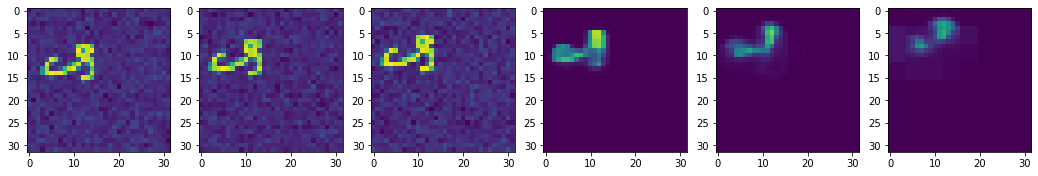

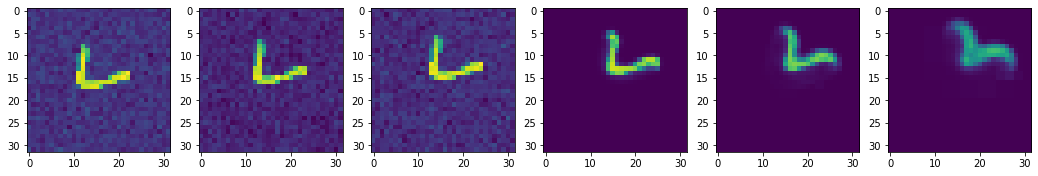

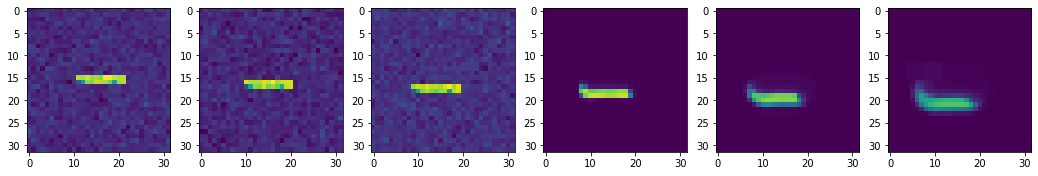

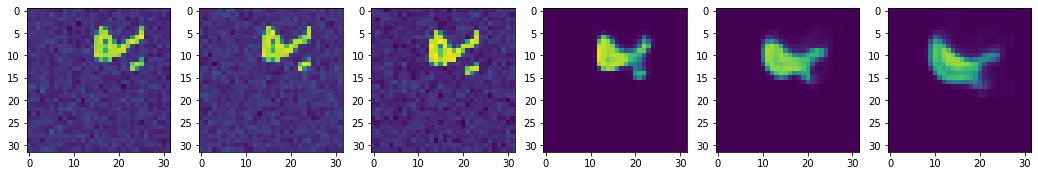

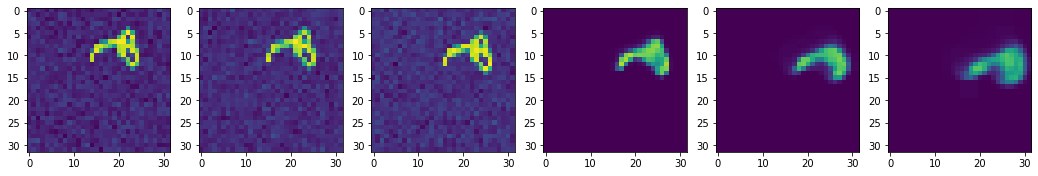

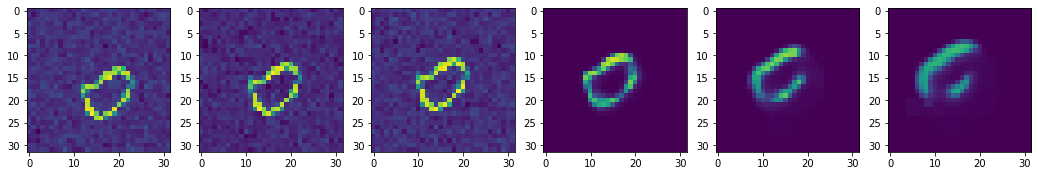

In [54]:
# Plot some example 
num_frames = 6

y_hat = model.predict(x_val[:num_frames])

for i in range(num_frames):
    fig, axs = plt.subplots(1, input_timesteps+output_timesteps, figsize=(3*(input_timesteps+output_timesteps), 4))
    
    # Inputs
    for j in range(input_timesteps):
        axs[j].imshow(x_val[i][j, ..., 0])
    
    for j in range(output_timesteps):
        axs[input_timesteps+j].imshow(y_hat[i][j][..., 0], vmin=0, vmax=1)  # Prediction

<AxesSubplot: >

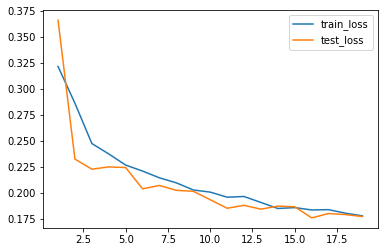

In [55]:
model.loss.iloc[1:].plot()